# Setup

### Import necessary modules and do some basic setup.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# TensorFlow ≥2.0 is required
import tensorflow_addons as tfa
import tensorflow as tf
assert tf.__version__ >= '2.0'

from tensorflow import keras
from tensorflow.keras import layers

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Common imports
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import dask
import datetime
import math
dask.config.set({'array.slicing.split_large_chunks': False})

# To make this notebook's output stable across runs
np.random.seed(42)

# Config matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Custom utils
from utils.utils_data import *
from utils.utils_ml import *
from utils.utils_plot import *

Num GPUs Available:  0


### Define some paths and constants.

In [2]:
# Paths
DATADIR = os.path.join(os.getcwd(), '..', 'data')

# Some constants
DATE_START = '1979-01-01'
DATE_END = '2020-12-31'
YY_TRAIN = [1979, 2015]
YY_TEST = [2016, 2020]

# Preparing precipitation data

RhiresD daily gridded dataset (MeteoSwiss) aggregated over 5 climatic regions + country-wise

<span><img src="images/RhiresD.png" alt="RhiresD" width="500"/></span>
<span><img src="images/Map_5_regions.jpg" alt="Map 5 regions" width="513"/></span>

In [3]:
# Read precipitation file
df_prec = get_precipitation_data(DATADIR + '/MeteoSwiss/precip_regions.csv',
                                 DATE_START, DATE_END)

df_prec = prepare_prec_data_by_aggregated_regions(df_prec, qt=0.95)
prec_cols = df_prec.columns[1:7]
prec_xtr_cols = df_prec.columns[7:13]

In [4]:
# Select regions of interest for following analyses (for example only 'reg_tot' or all sub-regions)
regions = ['reg_1', 'reg_2', 'reg_3', 'reg_4', 'reg_5', 'reg_tot']
regions_xtr = ['reg_1_xtr', 'reg_2_xtr', 'reg_3_xtr', 'reg_4_xtr', 'reg_5_xtr', 'reg_tot_xtr']
region_names = 2 * ['NW Switzerland', 'N Switzerland', 'Valais + Bernese Alps', 'E Switzerland', 'Ticino', 'country-wise']

# Preparing input data (predictors/features)

Dataset: ERA5 – the newest ECMWF atmospheric reanalysis
- Selected variables: geopotential height (Z), T° 2m
- Resolution: original 0.25° (30 km) => here at 0.5°
- Time steps: original hourly => here daily mean
- Vertical levels: original 37 vertical pressure levels => here 3 selected for Z [1000, 850, 500] hPa
- Selected domain: lat = [30, 80], lon = [-40, 40]

### Load data and resample

In [5]:
# Load original gridded data
z = get_era5_data(DATADIR + '/ERA5/geopotential/*.nc', DATE_START, DATE_END)
z = z.sel(level=[500, 850, 1000])
t2m = get_era5_data(DATADIR + '/ERA5/Daymean_era5_T2M_EU_19790101-20210905.nc', DATE_START, DATE_END)
t2m['time'] = pd.DatetimeIndex(t2m.time.dt.date)

lats = z.lat
lons = z.lon

Extracting data for the period 1979-01-01 - 2020-12-31


C:\Python39\lib\site-packages\dask\array\slicing.py:647: RuntimeWarning: overflow encountered in long_scalars
  maxsize = math.ceil(nbytes / (other_numel * itemsize))


Extracting data for the period 1979-01-01 - 2020-12-31


In [6]:
# Resample to lower resolution
resolution = 0.5

if resolution > 0.25:
    lons = np.arange(min(lons), max(lons), resolution)
    lats = np.arange(min(lats), max(lats), resolution)
    z = z.sel(lon=lons).sel(lat=lats)
    t2m = t2m.sel(lon=lons).sel(lat=lats)

In [7]:
# Add a level dimension to the 2D dataset
t2m = t2m.expand_dims('level', axis=1)

### Split data and transform

In [8]:
# Split set into (training + validation) and testing based on dates
z_train_full = z.sel(time=slice('{}-01-01'.format(YY_TRAIN[0]), '{}-12-31'.format(YY_TRAIN[1])))
z_test = z.sel(time=slice('{}-01-01'.format(YY_TEST[0]), '{}-12-31'.format(YY_TEST[1])))
t2m_train_full = t2m.sel(time=slice('{}-01-01'.format(YY_TRAIN[0]), '{}-12-31'.format(YY_TRAIN[1])))
t2m_test = t2m.sel(time=slice('{}-01-01'.format(YY_TEST[0]), '{}-12-31'.format(YY_TEST[1])))

y_train_full = df_prec[(df_prec.date.dt.year >= YY_TRAIN[0]) &
                       (df_prec.date.dt.year <= YY_TRAIN[1])]
y_test = df_prec[(df_prec.date.dt.year >= YY_TEST[0]) &
                 (df_prec.date.dt.year <= YY_TEST[1])]

In [9]:
# Transform to numpy arrays and concatenate (takes time as it needs to load data from files)
X_train_full = np.concatenate((np.squeeze(z_train_full.to_array().to_numpy(), axis=0),
                               np.squeeze(t2m_train_full.to_array().to_numpy(), axis=0)), axis=1)
X_test = np.concatenate((np.squeeze(z_test.to_array().to_numpy(), axis=0),
                         np.squeeze(t2m_test.to_array().to_numpy(), axis=0)), axis=1)

X_train_full.shape

(13514, 4, 100, 160)

In [10]:
# Split full training into training and validation sets (and shuffle)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

In [11]:
# Normalize data
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True)
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

# Reshape data (set channel first; Con2D option data_format='channels_first' does not work on Win 10 64 bit)
X_train = np.moveaxis(X_train, 1, -1)
X_valid = np.moveaxis(X_valid, 1, -1)
X_test = np.moveaxis(X_test, 1, -1)

X_train.shape

(10135, 100, 160, 4)

# CNN - Prediction of precipitation extremes

### Create the model

In [12]:
# Clear session and set tf seed
keras.backend.clear_session()
tf.random.set_seed(42)

# ANN using timeseries to predict precipitation
cnn_xtrm_v1 = keras.models.Sequential([
    layers.Input(shape=X_train.shape[1:]),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=2),
    layers.SpatialDropout2D(0.2),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=2),
    layers.SpatialDropout2D(0.2),
    layers.Flatten(),
    layers.Dense(16, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(len(regions_xtr), activation='sigmoid')
])

cnn_xtrm_v1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 160, 16)      592       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 160, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 80, 16)        0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 50, 80, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 80, 16)        2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 80, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 40, 16)        0

### Train the model

In [13]:
# Train the model

# Define hyperparameters
BATCH_SIZE = 64
EPOCHS = 30
INIT_LR = 1e-4
MAX_LR = 1e-2

# Cyclical learning rate
steps_per_epoch = len(X_train) // BATCH_SIZE
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
                                          maximal_learning_rate=MAX_LR,
                                          scale_fn=lambda x: 1/(2.**(x-1)),
                                          step_size=2 * steps_per_epoch)
optimizer = tf.keras.optimizers.Adam(clr)

# Compile model and train
cnn_xtrm_v1.compile(
    optimizer=optimizer,
    loss=WeightedBinaryCrossEntropy(
        pos_weight=5,
        weight=1,
        from_logits=False,
    )
)

history = cnn_xtrm_v1.fit(X_train,
                          y_train[regions_xtr].astype(float),
                          batch_size=BATCH_SIZE,
                          validation_data=(X_valid, y_valid[regions_xtr].astype(float)),
                          epochs=EPOCHS)


Epoch 1/30
159/159 [==============================] - 92s 565ms/step - loss: 0.7333 - val_loss: 0.5001
Epoch 2/30
159/159 [==============================] - 83s 523ms/step - loss: 0.4008 - val_loss: 0.4275
Epoch 3/30
159/159 [==============================] - 89s 563ms/step - loss: 0.3597 - val_loss: 0.3156
Epoch 4/30
159/159 [==============================] - 83s 521ms/step - loss: 0.3313 - val_loss: 0.3034
Epoch 5/30
159/159 [==============================] - 82s 514ms/step - loss: 0.3234 - val_loss: 0.2980
Epoch 6/30
159/159 [==============================] - 86s 541ms/step - loss: 0.3246 - val_loss: 0.3090
Epoch 7/30
159/159 [==============================] - 82s 516ms/step - loss: 0.3190 - val_loss: 0.2890
Epoch 8/30
159/159 [==============================] - 83s 521ms/step - loss: 0.3051 - val_loss: 0.2831
Epoch 9/30
159/159 [==============================] - 83s 520ms/step - loss: 0.2982 - val_loss: 0.2831
Epoch 10/30
159/159 [==============================] - 82s 518ms/step - l

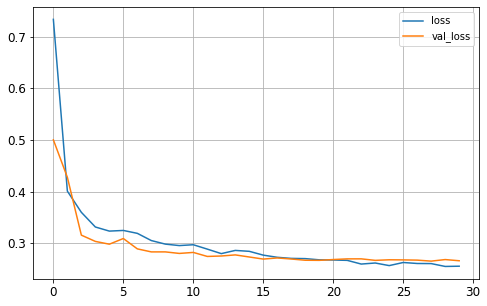

In [14]:
# Plot training evolution
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

### Predict the test period and evaluate

In [15]:
# Predict and evaluate the extremes
y_pred_train = cnn_xtrm_v1.predict(X_train)
y_pred_test = cnn_xtrm_v1.predict(X_test)

y_pred_train_bool = y_pred_train >= 0.5
y_pred_test_bool = y_pred_test >= 0.5

# Confusion matrix per region (x: prediction; y: true value)
# [[TN, FP] 
# [ FN, TP]]
for idx, region in enumerate(regions_xtr):
    cnf_matrix = confusion_matrix(y_test[region], y_pred_test_bool[:, idx])
    print(f"Confusion matrix {region}:\n {cnf_matrix}")

Confusion matrix reg_1_xtr:
 [[1723   23]
 [  59   22]]
Confusion matrix reg_2_xtr:
 [[1699   32]
 [  68   28]]
Confusion matrix reg_3_xtr:
 [[1715   27]
 [  52   33]]
Confusion matrix reg_4_xtr:
 [[1706   27]
 [  60   34]]
Confusion matrix reg_5_xtr:
 [[1712   32]
 [  35   48]]
Confusion matrix reg_tot_xtr:
 [[1706   39]
 [  39   43]]


Recall Baseline: 1.0 Test: 0.52 Train: 0.69
Precision Baseline: 0.04 Test: 0.52 Train: 0.63
Roc Baseline: 0.5 Test: 0.94 Train: 0.98


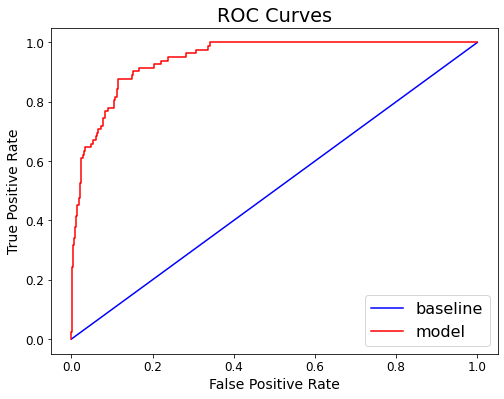

In [16]:
# Results for the whole country
evaluate_model(y_test.reg_tot_xtr, y_train.reg_tot_xtr, y_pred_test_bool[:, -1],
                y_pred_test[:, -1], y_pred_train_bool[:, -1], y_pred_train[:, -1])

# Visualization

## Visualizing filters

Filters of layer conv2d with shape (3, 3, 4, 16):


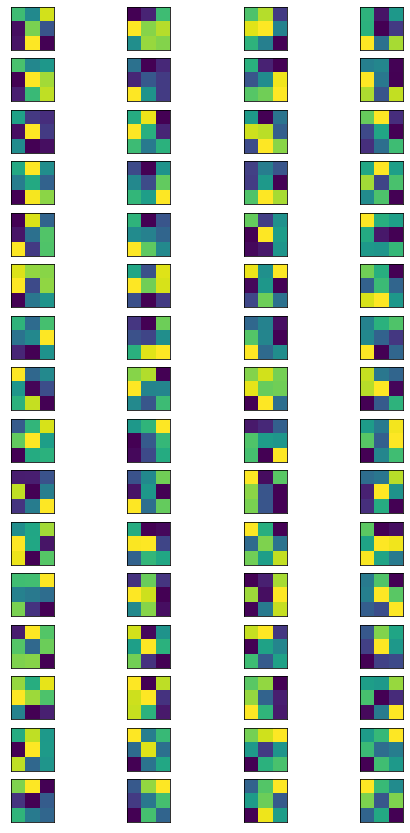

Filters of layer conv2d_1 with shape (3, 3, 16, 16):


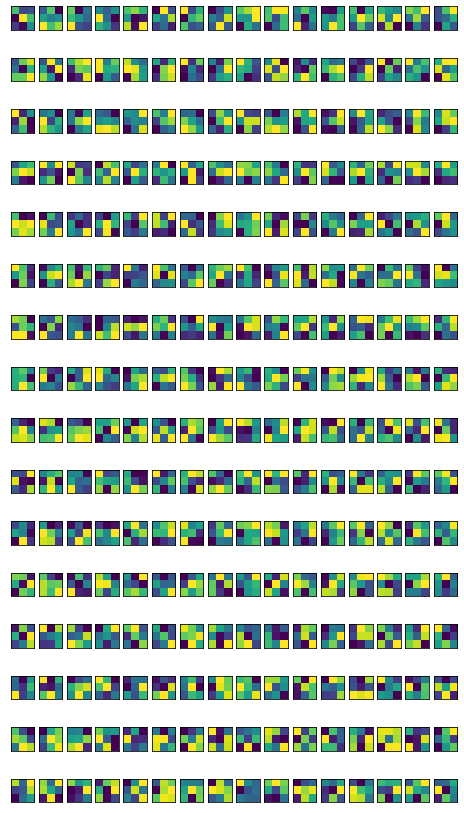

In [17]:
normalize_weights = False

# Extract weights from convolutional layers
for layer in cnn_xtrm_v1.layers:
    if 'conv' in layer.name:
        weights, bias = layer.get_weights()
        print(f'Filters of layer {layer.name} with shape {weights.shape}:')

        # Optionally normalize filter values for visualization
        if normalize_weights:
            filters = (weights - weights.min()) / (weights.max() - weights.min())
        else:
            filters = weights

        # Create figure
        fig = plt.figure(figsize=[8, 15])

        # Plotting the filters
        filter_cnt = 1
        for i_unit in range(filters.shape[3]):

            # Get the filters for the selected unit
            filter = filters[:, :, :, i_unit]

            # Plotting each of the channel
            for i_channel in range(filters.shape[2]):
                ax = plt.subplot(filters.shape[3], filters.shape[2], filter_cnt)
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(filter[:, :, i_channel])
                filter_cnt += 1

        plt.show()


## Visualizing feature maps

### Extract CNN layers and create the visualization model

In [18]:
# Extract layer names and outputs
layer_names = [layer.name for layer in cnn_xtrm_v1.layers]
layer_outputs = [layer.output for layer in cnn_xtrm_v1.layers]
layer_outputs

[<KerasTensor: shape=(None, 100, 160, 16) dtype=float32 (created by layer 'conv2d')>,
 <KerasTensor: shape=(None, 100, 160, 16) dtype=float32 (created by layer 'batch_normalization')>,
 <KerasTensor: shape=(None, 50, 80, 16) dtype=float32 (created by layer 'max_pooling2d')>,
 <KerasTensor: shape=(None, 50, 80, 16) dtype=float32 (created by layer 'spatial_dropout2d')>,
 <KerasTensor: shape=(None, 50, 80, 16) dtype=float32 (created by layer 'conv2d_1')>,
 <KerasTensor: shape=(None, 50, 80, 16) dtype=float32 (created by layer 'batch_normalization_1')>,
 <KerasTensor: shape=(None, 25, 40, 16) dtype=float32 (created by layer 'max_pooling2d_1')>,
 <KerasTensor: shape=(None, 25, 40, 16) dtype=float32 (created by layer 'spatial_dropout2d_1')>,
 <KerasTensor: shape=(None, 16000) dtype=float32 (created by layer 'flatten')>,
 <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'dense')>,
 <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'batch_normalization_2')>,
 <KerasT

In [19]:
# Create the visualization model
feature_map_model = tf.keras.models.Model(inputs=cnn_xtrm_v1.input,
                                          outputs=layer_outputs)


### Create plotting and utility functions

In [20]:
# Create functions to plot predictors

def add_to_plot(fig, axs, var, title, i, j, lons, lats):
    im = axs[i, j].pcolormesh(lons, lats, var[0,:,:], cmap=mpl.cm.RdYlBu_r, shading='auto')

    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world.boundary.plot(ax=axs[i, j], color='k')

    axs[i, j].set_xlim(min(lons), max(lons))
    axs[i, j].set_ylim(min(lats), max(lats))
    axs[i, j].set_title(title)

    fig.colorbar(im, ax=axs[i, j])

def plot_predictors(z, t2m, date_slct):

    # Create figure
    fig, axs = plt.subplots(2, 2, figsize=[12, 7])

    # Add plots
    z_xtreme = z.sel(time=date_slct)
    t2m_xtreme = t2m.sel(time=date_slct)

    add_to_plot(fig, axs, z_xtreme.sel(level=500).to_array(), 'Z500', 0, 0, lons, lats)
    add_to_plot(fig, axs, z_xtreme.sel(level=850).to_array(), 'Z850', 0, 1, lons, lats)
    add_to_plot(fig, axs, z_xtreme.sel(level=1000).to_array(), 'Z1000', 1, 0, lons, lats)
    add_to_plot(fig, axs, t2m_xtreme.sel(level=0).to_array(), 'T2m', 1, 1, lons, lats)

    plt.tight_layout()

In [21]:
# Create function to plot feature maps

def plot_feature_maps(feature_maps, show_pooling=False):
    scale_features = True
    fig_ratio = 1

    for layer_name, feature_map in zip(layer_names, feature_maps):
        # Get rid of dense layers
        if len(feature_map.shape) < 4:
            continue

        # Get rid of normalization and droupout layers
        if 'normalization' in layer_name or 'dropout' in layer_name:
            continue

        # Skip pooling layer if not desired
        if not show_pooling and 'pooling' in layer_name:
            continue

        print(f"The shape of {layer_name} is {feature_map.shape}")

        # Extract all features and their sizes
        n_features = feature_map.shape[-1]
        size_h = feature_map.shape[1]
        size_v = feature_map.shape[2]
        fig_ratio = size_v / size_h

        # Create the figure
        n_cols = 4
        n_rows = math.ceil(n_features / n_cols)
        scale = 10. / n_cols
        fig, axs = plt.subplots(n_rows, n_cols,
                                figsize=(scale * n_cols * fig_ratio, scale * n_rows))

        # Load country outlines
        world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

        # Process the lat/lon axes
        ax_lons = np.linspace(min(lons), max(lons), size_v)
        ax_lats = np.linspace(min(lats), max(lats), size_h)

        # Extract all features
        for i_feature in range(n_features):
            x = feature_map[0, :, :, i_feature]

            # Scale to improve visibility
            if scale_features:
                x -= x.mean()
                x /= x.std()
                x *= 64
                x += 128
                x = np.clip(x, 0, 255).astype('uint8')

            # Plot feature
            i_row = i_feature % n_cols
            i_col = i_feature // n_cols
            im = axs[i_row, i_col].pcolormesh(ax_lons, ax_lats, x, cmap='viridis', shading='auto')

            # Add country contours
            world.boundary.plot(ax=axs[i_row, i_col], color='k')
            axs[i_row, i_col].set_xlim(min(lons), max(lons))
            axs[i_row, i_col].set_ylim(min(lats), max(lats))
            axs[i_row, i_col].axis('off')

        fig.suptitle(layer_name)
        plt.grid(False)
        plt.tight_layout()

In [22]:
# Create function to select the best predicted date

def get_best_predicted_date(target, y_pred_test, y_test, X_test, regions_xtr):
    target_col = regions_xtr.index(target)
    pred_prob = y_pred_test[y_test[target] == True, target_col]
    i_xtreme = pred_prob.argmax()
    date_xtreme = y_test[y_test[target] == True].iloc[i_xtreme].date
    formatted_date = datetime.date.strftime(date_xtreme, "%d.%m.%Y")
    print('An extreme event was predicted with a probability of ' 
        f'{round(100 * pred_prob[i_xtreme], 1)}% for the {formatted_date}')

    # Extract inputs for that date
    data_xtreme = X_test[y_test[target] == True][i_xtreme]
    data_xtreme = data_xtreme.reshape((1,) + data_xtreme.shape)

    return date_xtreme, data_xtreme


### Select days with extreme precipitation for different regions
Regions: 
- reg_1_xtr (NW CH)
- reg_2_xtr (N CH)
- reg_3_xtr (Valais + Bernese Alps)
- reg_4_xtr (E CH)
- reg_5_xtr (Ticino)
- reg_tot_xtr (total)

### Extreme precipitation event in the whole country

Same date as for the Valais + Bernese Alps

An extreme event was predicted with a probability of 91.3% for the 22.05.2016
The shape of conv2d is (1, 100, 160, 16)
The shape of max_pooling2d is (1, 50, 80, 16)
The shape of conv2d_1 is (1, 50, 80, 16)
The shape of max_pooling2d_1 is (1, 25, 40, 16)


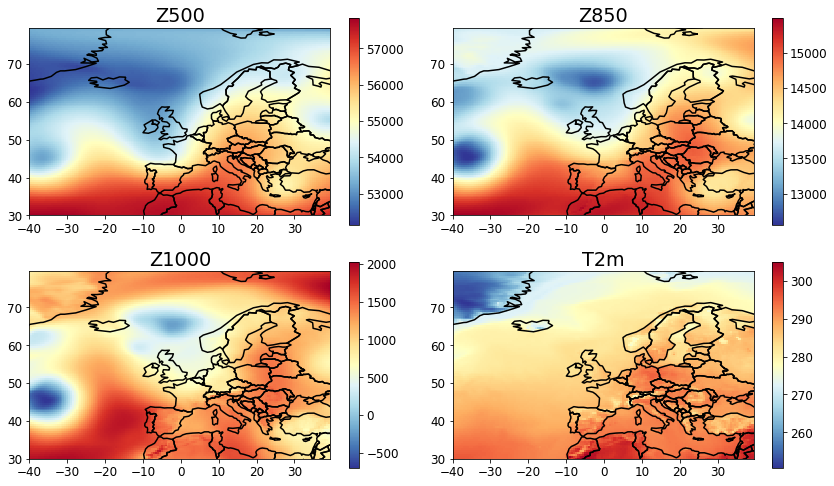

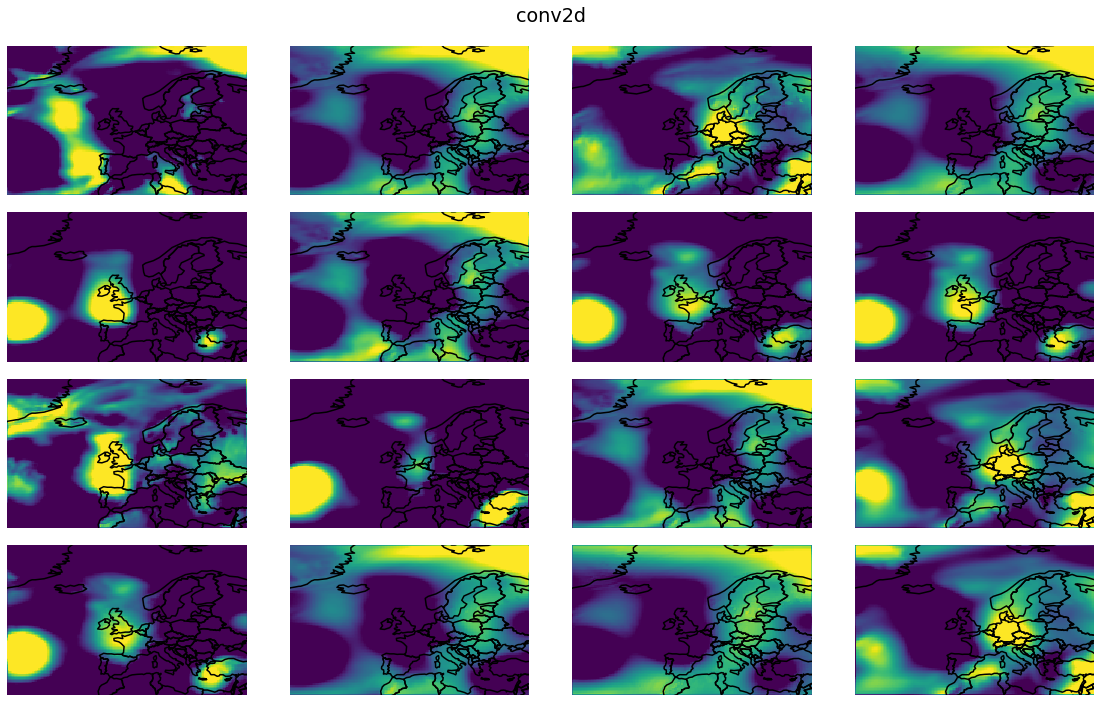

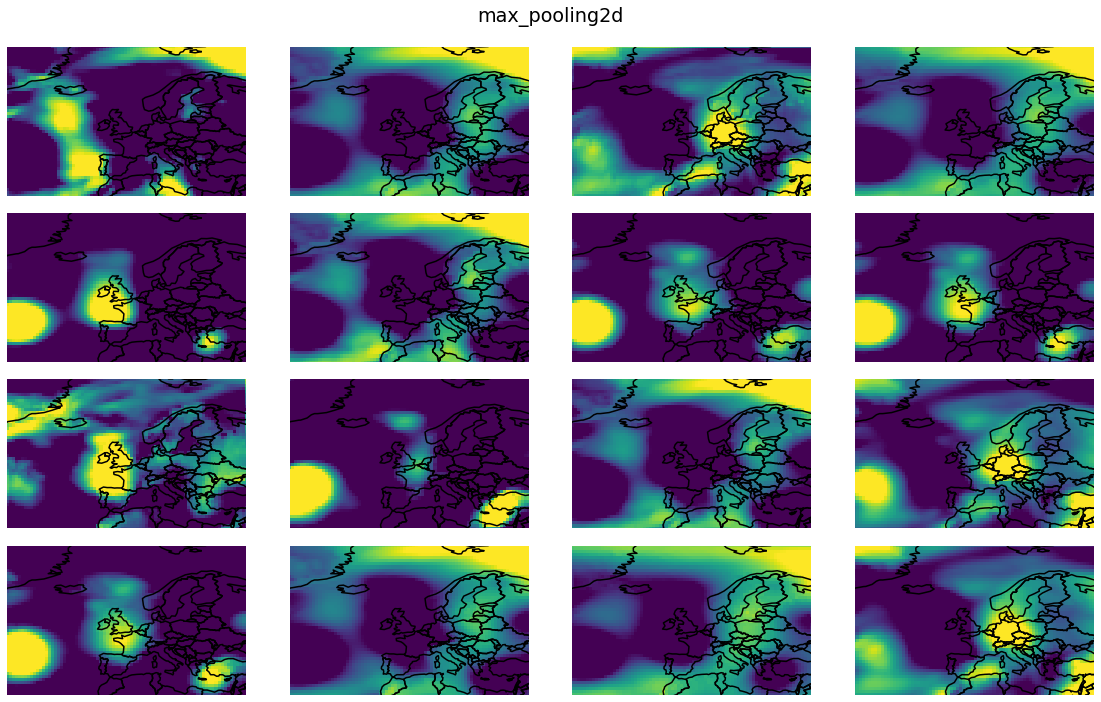

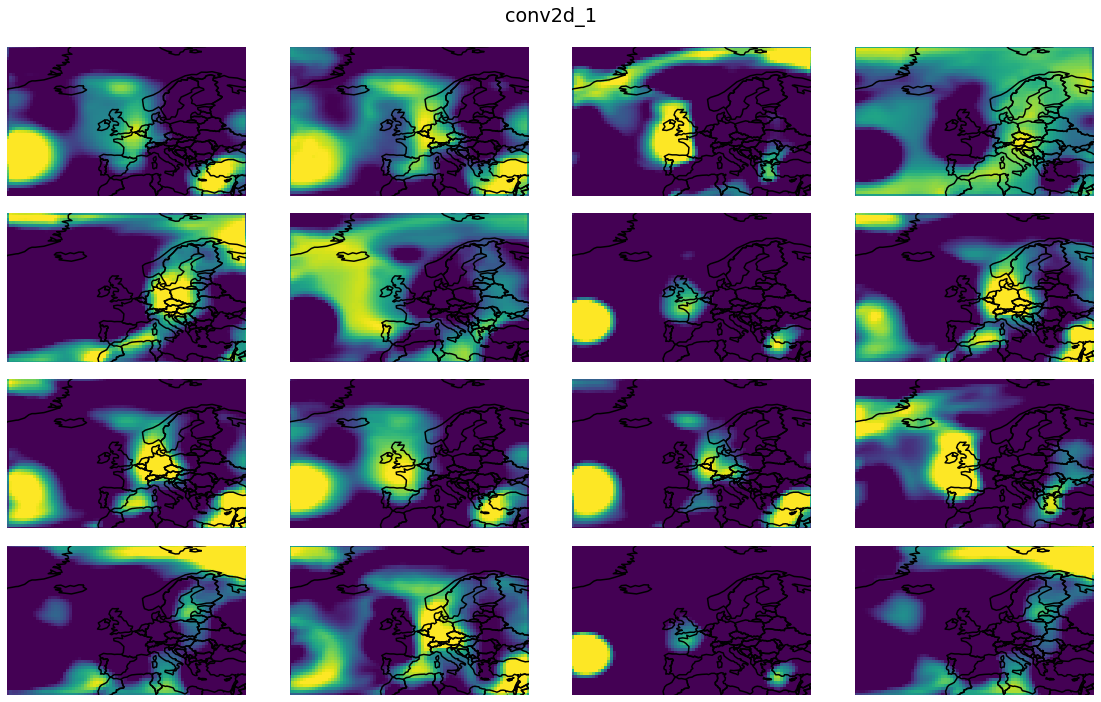

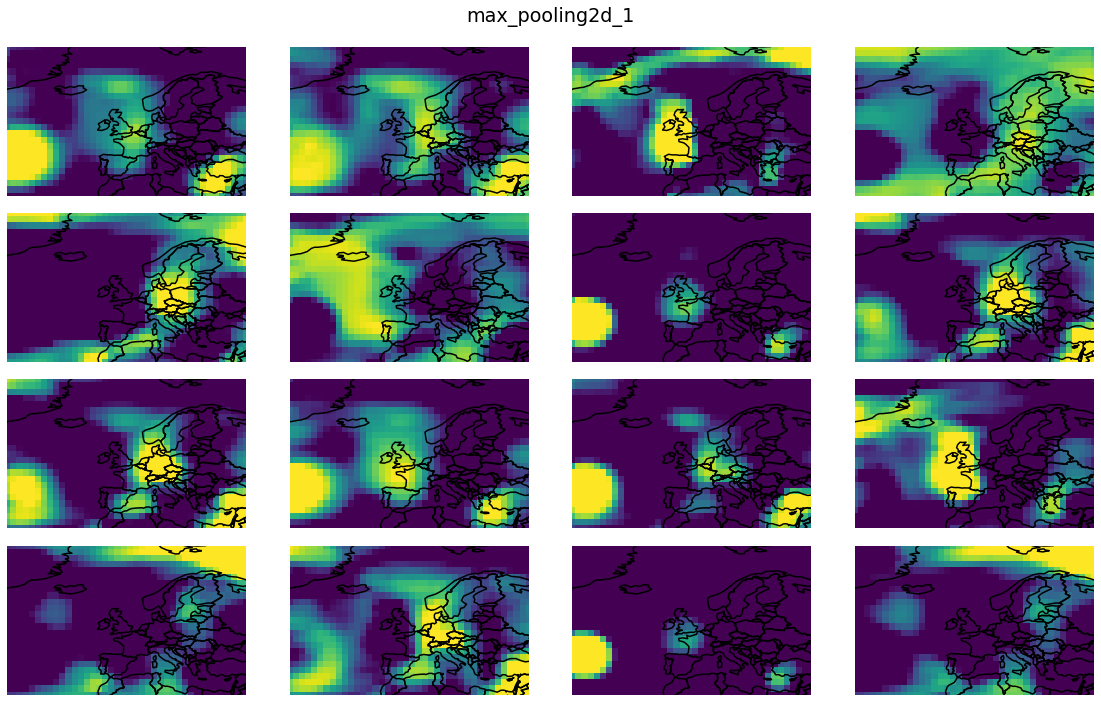

In [23]:
# Select a day that was well predicted
target = 'reg_tot_xtr'
date_xtreme, data_xtreme = get_best_predicted_date(target, y_pred_test, y_test, X_test, regions_xtr)

# Plot predictors
plot_predictors(z, t2m, date_xtreme)

# Feed the inputs of the extreme day into the model created
feature_maps = feature_map_model.predict(data_xtreme)

# Plot the feature maps
plot_feature_maps(feature_maps, show_pooling=True)


### Extreme precipitation event in NW Switzerland

An extreme event was predicted with a probability of 81.3% for the 14.03.2019
The shape of conv2d is (1, 100, 160, 16)
The shape of conv2d_1 is (1, 50, 80, 16)


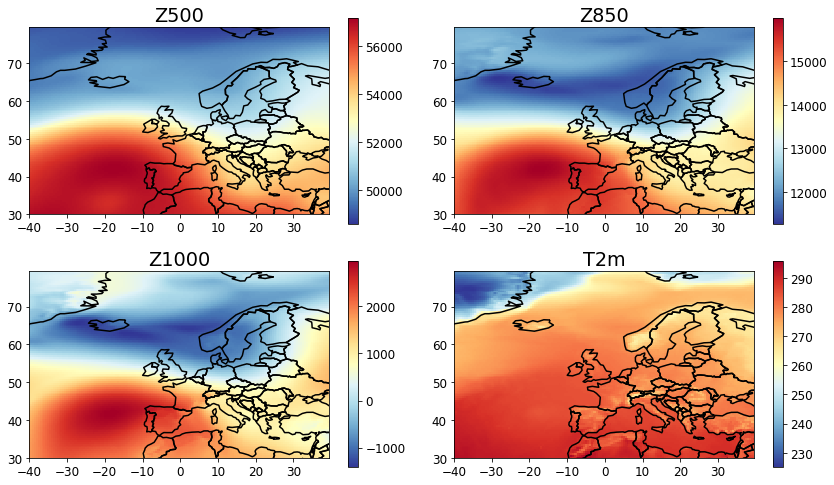

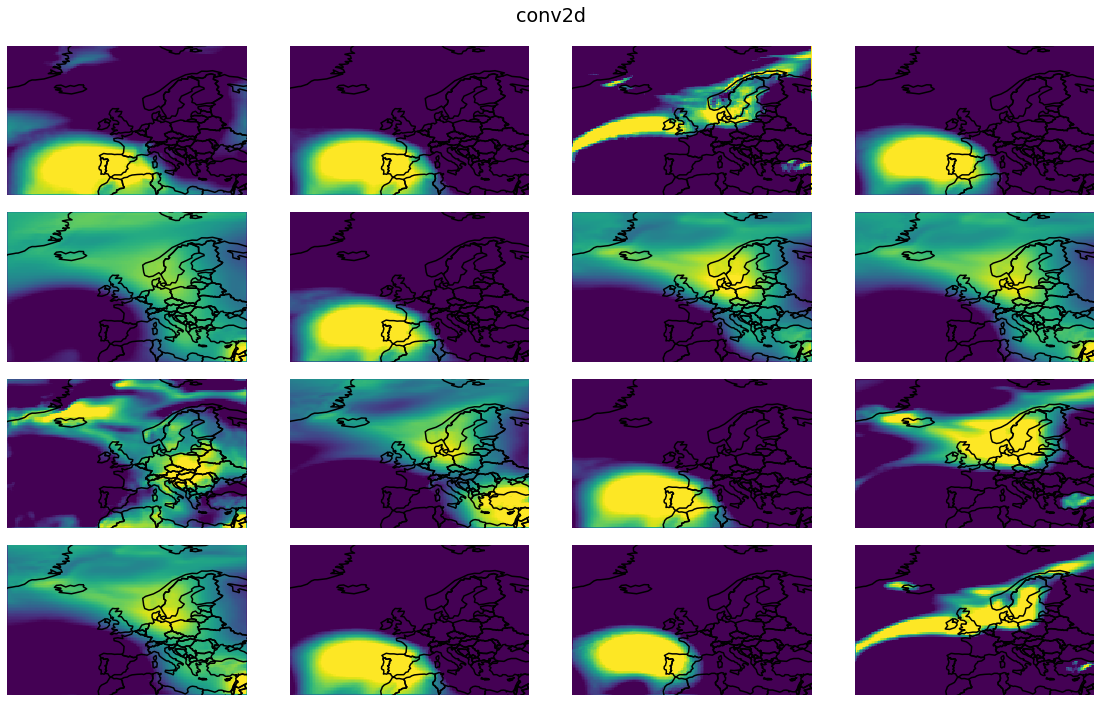

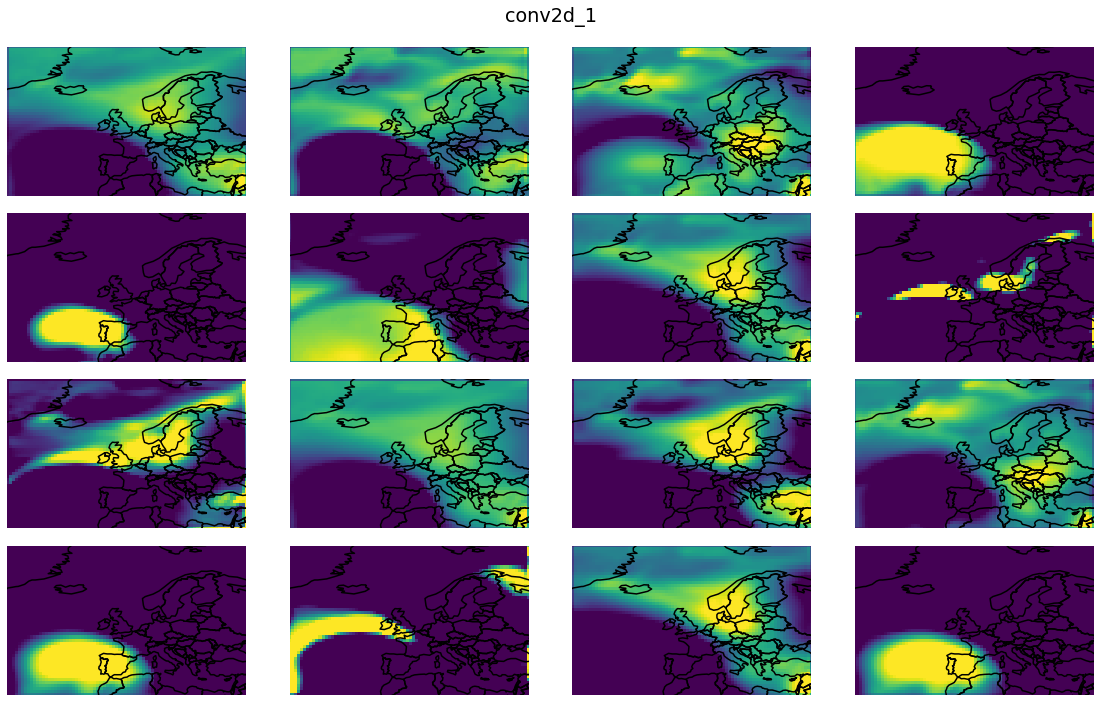

In [24]:
# Select a day that was well predicted
target = 'reg_1_xtr'
date_xtreme, data_xtreme = get_best_predicted_date(target, y_pred_test, y_test, X_test, regions_xtr)

# Plot predictors
plot_predictors(z, t2m, date_xtreme)

# Feed the inputs of the extreme day into the model created
feature_maps = feature_map_model.predict(data_xtreme)

# Plot the feature maps
plot_feature_maps(feature_maps)


### Extreme precipitation event in E Switzerland

Same date as for N Switzerland

An extreme event was predicted with a probability of 93.2% for the 30.08.2020
The shape of conv2d is (1, 100, 160, 16)
The shape of conv2d_1 is (1, 50, 80, 16)


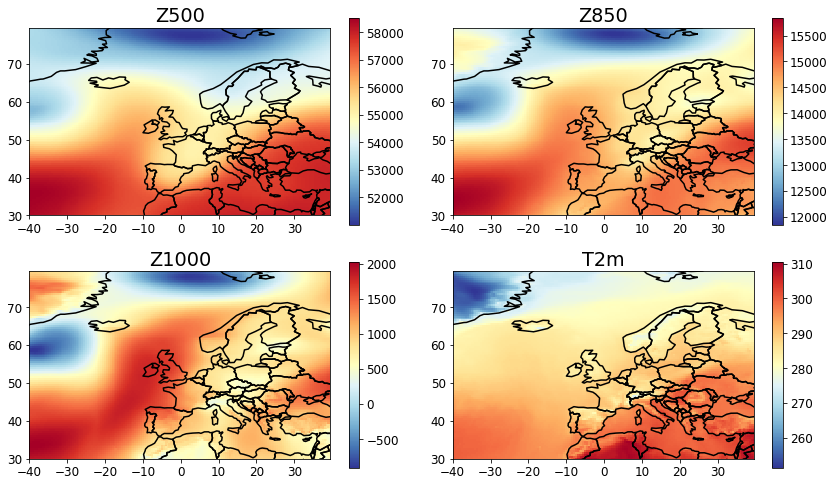

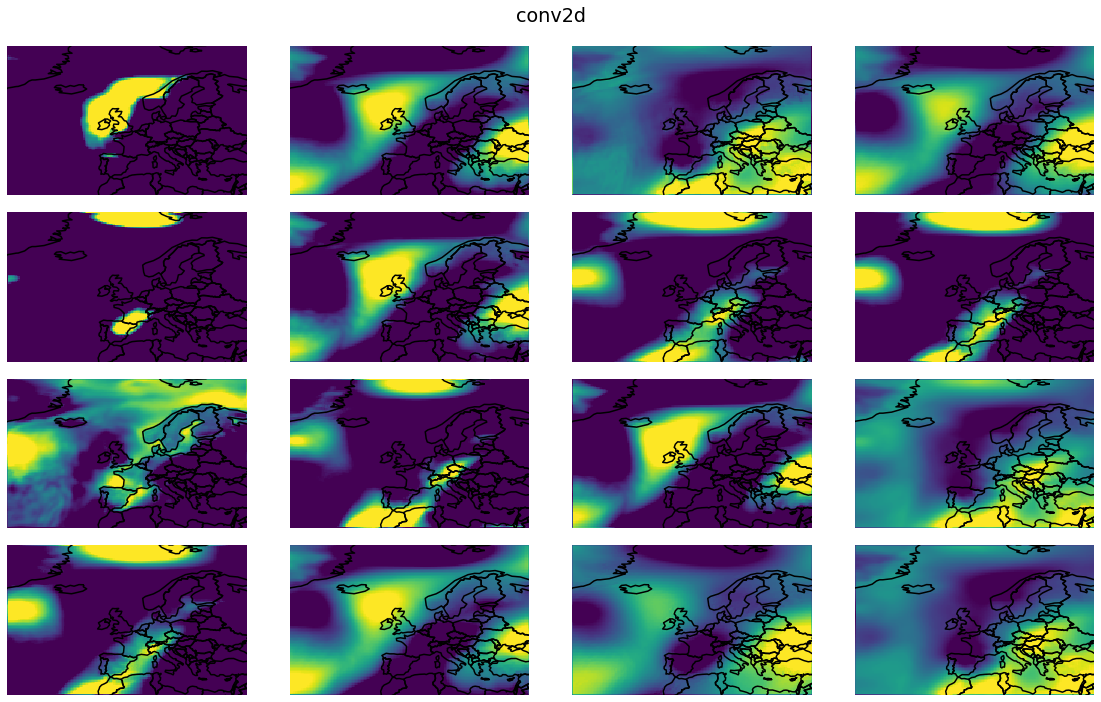

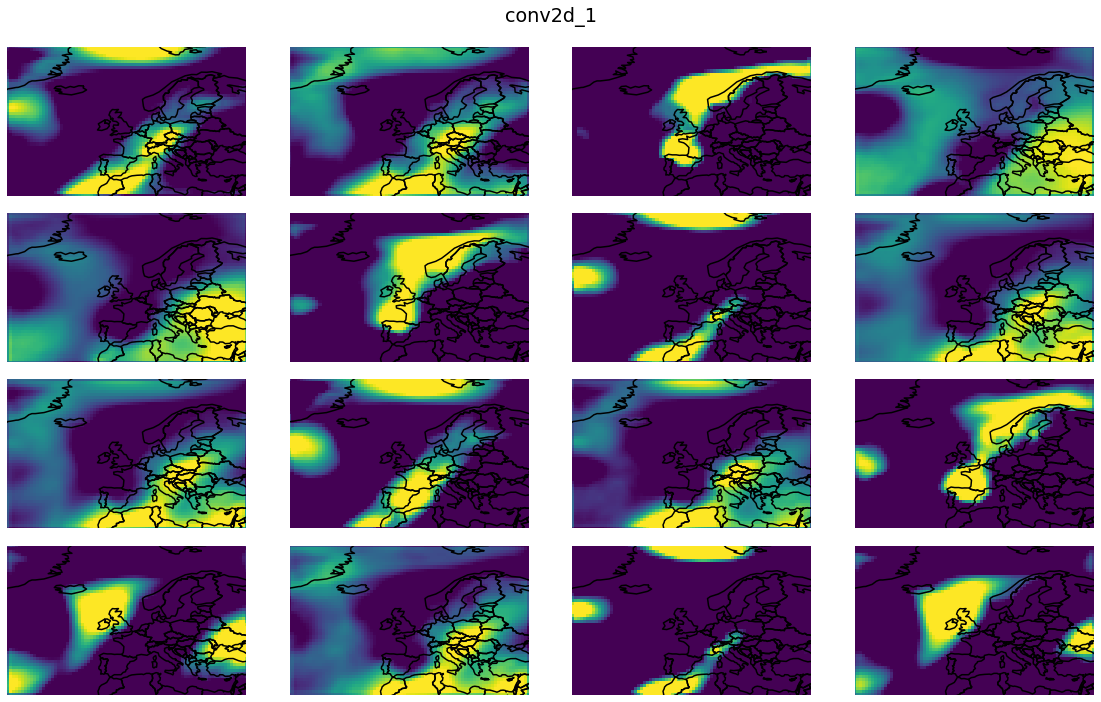

In [25]:
# Select a day that was well predicted
target = 'reg_4_xtr'
date_xtreme, data_xtreme = get_best_predicted_date(target, y_pred_test, y_test, X_test, regions_xtr)

# Plot predictors
plot_predictors(z, t2m, date_xtreme)

# Feed the inputs of the extreme day into the model created
feature_maps = feature_map_model.predict(data_xtreme)

# Plot the feature maps
plot_feature_maps(feature_maps)

### Extreme precipitation event in Ticino

An extreme event was predicted with a probability of 98.8% for the 29.10.2018
The shape of conv2d is (1, 100, 160, 16)
The shape of conv2d_1 is (1, 50, 80, 16)


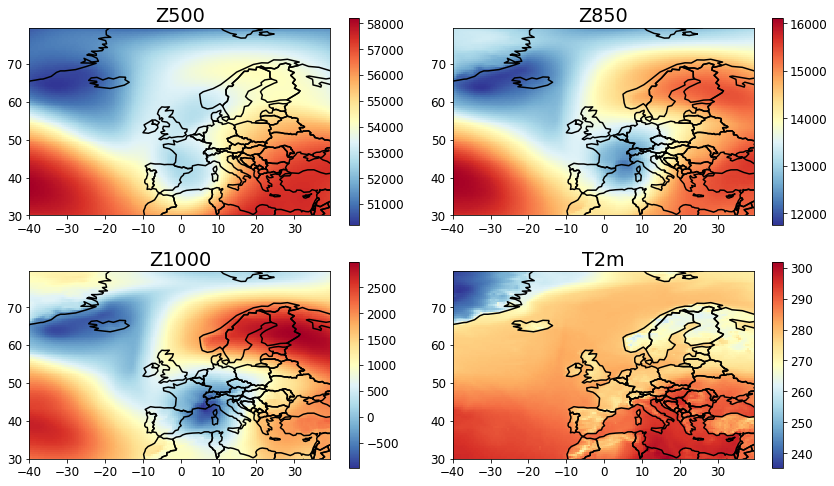

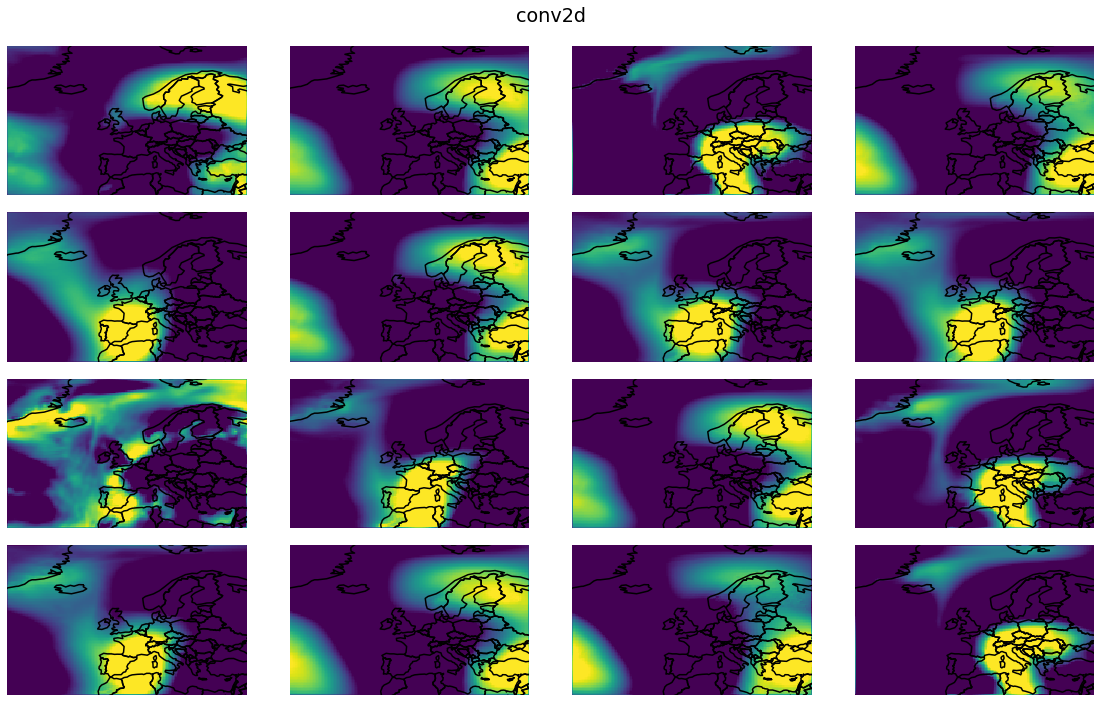

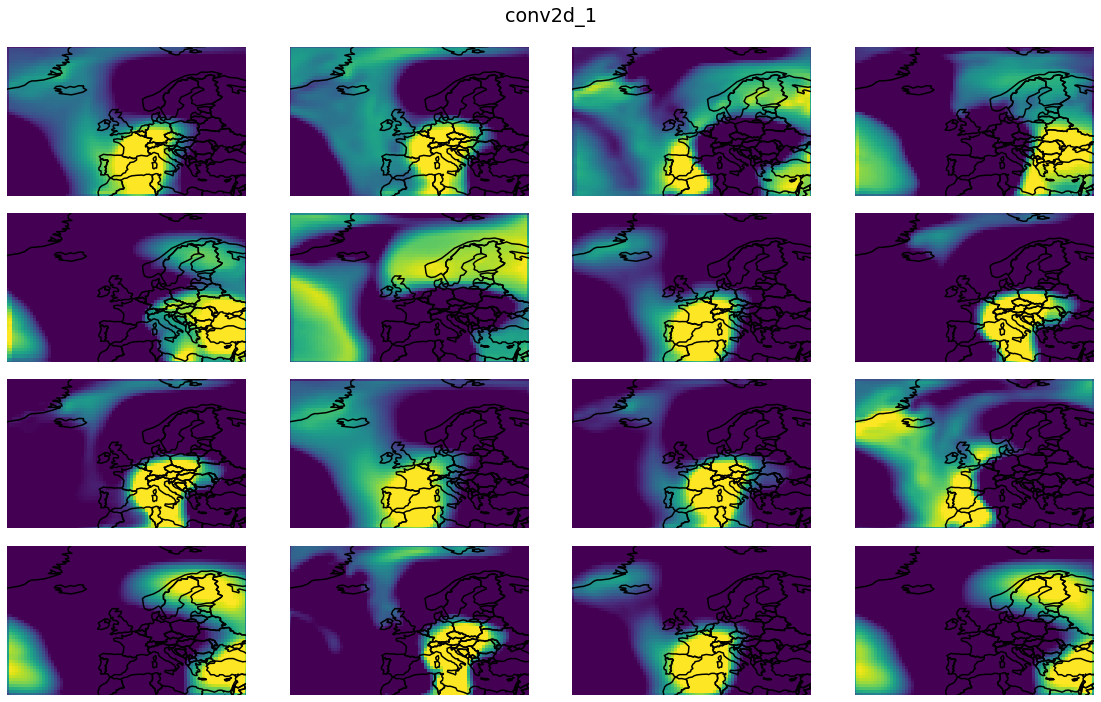

In [26]:
# Select a day that was well predicted
target = 'reg_5_xtr'
date_xtreme, data_xtreme = get_best_predicted_date(target, y_pred_test, y_test, X_test, regions_xtr)

# Plot predictors
plot_predictors(z, t2m, date_xtreme)

# Feed the inputs of the extreme day into the model created
feature_maps = feature_map_model.predict(data_xtreme)

# Plot the feature maps
plot_feature_maps(feature_maps)

## Visualizing dense layer

### Extract hidden dense layer and create the visualization model

In [27]:
# Access to the hidden dense layer
cnn_xtrm_v1.layers[-4].name

'dense'

In [28]:
# Create the visualization model
dense_act_model = tf.keras.models.Model(inputs=cnn_xtrm_v1.input,
                                        outputs=[cnn_xtrm_v1.layers[-4].output])

In [29]:
# Feed the inputs of the test period into the created model
dense_activations = dense_act_model.predict(X_test)

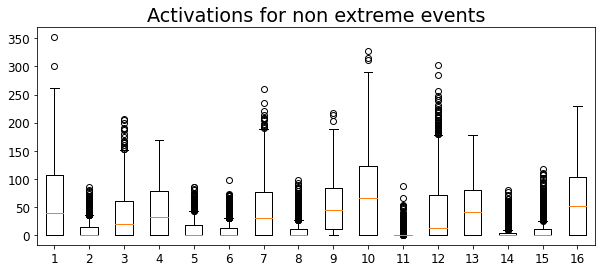

In [30]:
# Activations for non extremes

# Not observed in any region
non_events_obs = (~y_test.select_dtypes(bool)).all(axis='columns')

# Nor forecasted (p < 0.1)
non_events_pred = y_pred_test < 0.1
non_events_pred = non_events_pred.all(axis=1)

# Select activations for non events
non_events = non_events_obs.to_numpy() & non_events_pred
act_non_events = dense_activations[non_events]

# Plot
plt.figure(figsize=(10, 4))
plt.boxplot(act_non_events)
plt.title('Activations for non extreme events')

# Extract median
non_events_med = np.median(act_non_events, axis=0)


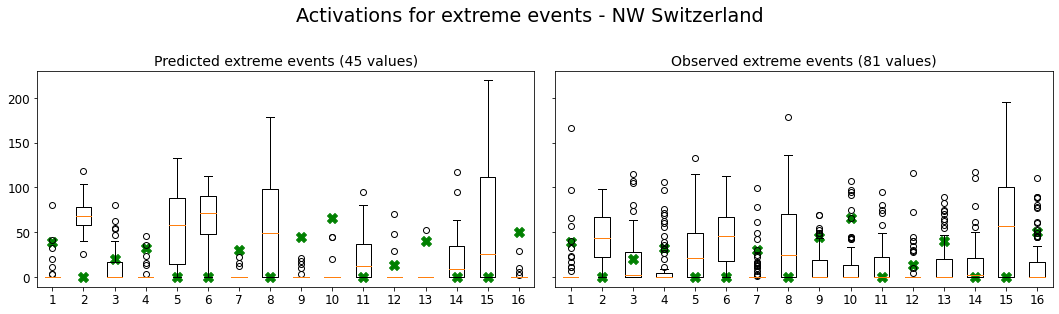

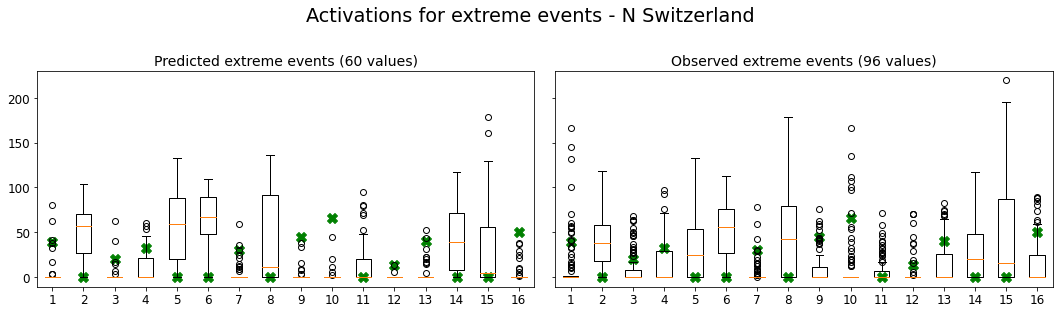

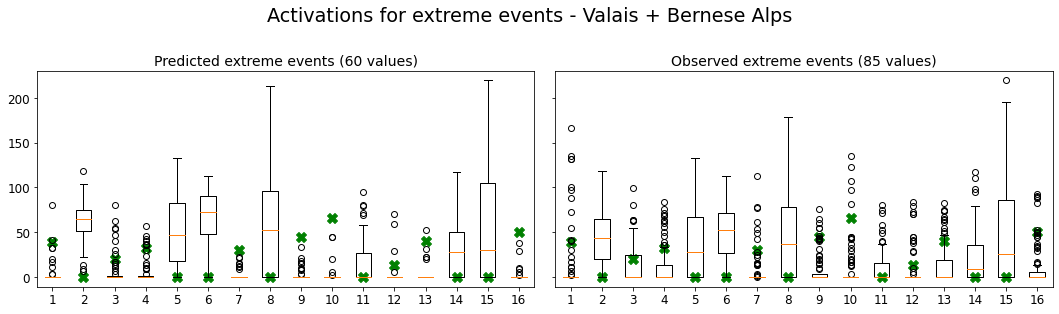

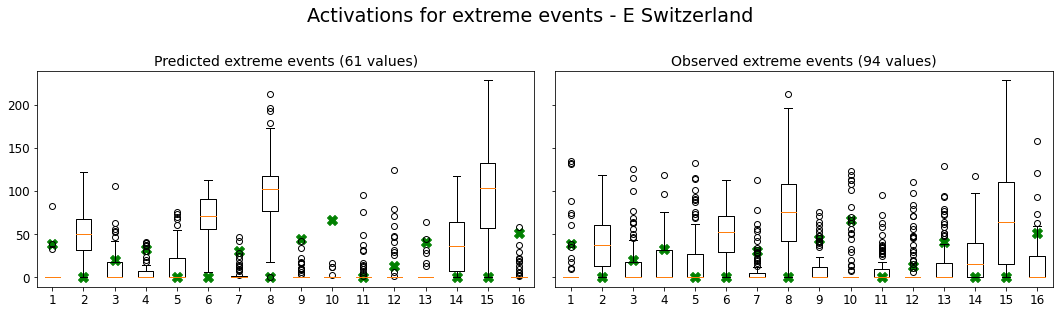

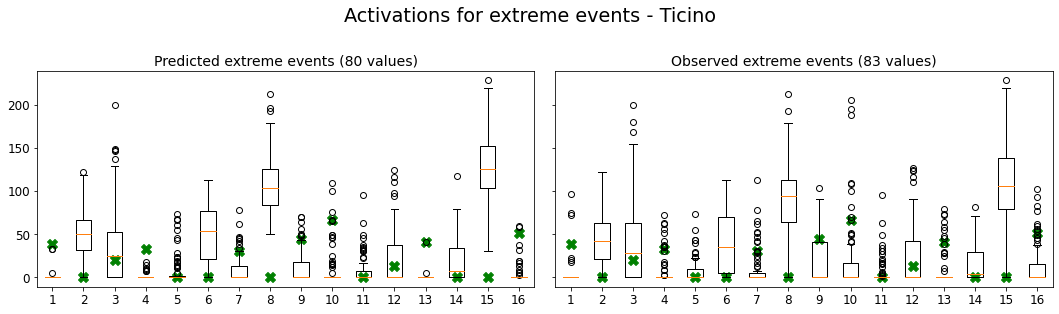

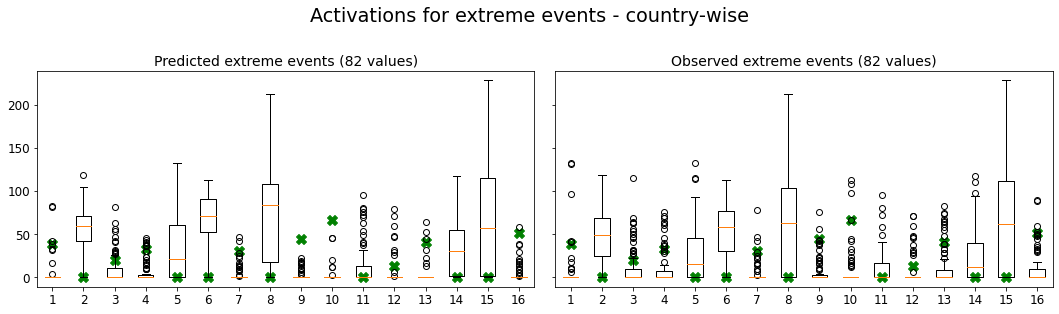

In [31]:
# Plot activations based on true labels

for idx, region in enumerate(regions_xtr):
    fig, axes = plt.subplots(1, 2, figsize=(15, 4.5), sharey=True)

    xtreme_pred_region = y_pred_test[:, idx] > 0.5
    xtreme_activations = dense_activations[xtreme_pred_region]
    axes[0].boxplot(xtreme_activations)
    axes[0].scatter(range(1, len(non_events_med) + 1), non_events_med, marker='X', s=100, c='g')
    axes[0].set_title(f'Predicted extreme events ({xtreme_activations.shape[0]} values)', fontsize=14)
    
    xtreme_obs_region = y_test[region]
    xtreme_activations = dense_activations[xtreme_obs_region]
    axes[1].boxplot(xtreme_activations)
    axes[1].scatter(range(1, len(non_events_med) + 1), non_events_med, marker='X', s=100, c='g')
    axes[1].set_title(f'Observed extreme events ({xtreme_activations.shape[0]} values)', fontsize=14)

    fig.suptitle('Activations for extreme events - ' + region_names[idx])
    fig.tight_layout()